In [63]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.filters import sobel
from skimage.morphology import erosion, footprint_rectangle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [64]:
# Parameters
img_height = 100
img_width = 100
num_classes = 11  # 10 known classes + 1 for "other" class (-1)

In [65]:
def enhance_image(img, selem):
    """Apply morphological erosion and edge detection to enhance features"""
    img_2d = img.reshape(img_height, img_width)
    eroded_image = erosion(img_2d, selem)
    edge_sobel = sobel(eroded_image)
    return edge_sobel

def preprocess_data(X, is_training=False):
    """Preprocess image data with normalization and feature enhancement"""
    # Normalize pixel values
    X_normalized = X / 255.0
    
    # Apply feature enhancement
    selem = footprint_rectangle((3, 3))
    X_enhanced = np.array([enhance_image(img, selem) for img in X_normalized])
    
    # Convert to PyTorch tensors
    X_tensor = torch.from_numpy(X_enhanced.reshape(-1, 1, img_height, img_width)).float()
    
    return X_tensor

In [66]:
class CNN(nn.Module):
    def __init__(self, num_classes=11):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)
        
        self.flatten = nn.Flatten()
        # Calculate the correct flattened size
        # After 3 pooling layers (divide by 2^3 = 8)
        flat_features = 128 * (img_height // 8) * (img_width // 8)
        
        self.fc1 = nn.Linear(flat_features, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # x is already shaped as [batch_size, 1, height, width]
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [67]:
def train(data, targets, epochs=35, batch_size=32, lr=0.001, weight_decay=1e-5, save_model=True):
    """Train function that loads data and trains the CNN model"""
    
    print(f"Data shape: {data.shape}")
    print(f"Targets shape: {targets.shape}")

    # Convert the inputs to tensor
    X_train_tensor = preprocess_data(data, is_training=True)
    t_train_tensor = torch.from_numpy(targets).long()

    # Create data loader for training only
    train_loader = DataLoader(
        TensorDataset(X_train_tensor, t_train_tensor),
        batch_size=batch_size,
        shuffle=True  # Shuffle training data each epoch
    )

    # Initialize model, loss function, and optimizer
    model = CNN(num_classes=num_classes)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    print("Starting training...")
    train_losses = []
    train_accs = []

    for epoch in range(epochs):
        # --- Training phase ---
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Loop over training batches
        for inputs, batch_targets in train_loader:
            optimizer.zero_grad()         # Reset gradients
            outputs = model(inputs)       # Forward pass
            loss = loss_fn(outputs, batch_targets) # Calculate loss
            loss.backward()               # Backward pass (calculate gradients)
            optimizer.step()              # Update weights

            # Accumulate loss and accuracy stats for the epoch
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += batch_targets.size(0)
            correct += (predicted == batch_targets).sum().item()

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / total # Use total samples seen in the epoch
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Print epoch results (only training stats)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    # Save the final model
    if save_model:
        save_path = 'greek_letter_model.pth'
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

    # Plot training loss and accuracy only
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training Accuracy')

    plt.tight_layout()
    plt.show()

    return model

In [68]:
def test(data, labels, model_path, batch_size=32):
    """Test function that evaluates model performance on test data"""
    
    print(f"Test data shape: {data.shape}")
    print(f"Test labels shape: {labels.shape}")
    
    # Preprocess test data
    X_test_tensor = preprocess_data(data)
    t_test_tensor = torch.from_numpy(labels).long()
    
    # Create test data loader
    test_loader = DataLoader(
        TensorDataset(X_test_tensor, t_test_tensor),
        batch_size=batch_size
    )
    
    # Load model
    model = CNN(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Evaluation
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Calculate accuracy and other metrics
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    accuracy = accuracy_score(all_targets, all_preds)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds, zero_division=0))
    
    # Plot confusion matrix
    class_labels = ['alpha', 'beta', 'gamma', 'delta', 'epsilon', 'eta', 'theta', 'lambda', 'mu', 'pi', 'other']
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    
    # Add text annotations to the confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return accuracy, all_preds

In [69]:
def test_hard(data, labels, model_path, batch_size=32, confidence_threshold=0.8):
    """Test function for the hard test set with unknown class detection"""
  
    print(f"Hard test data shape: {data.shape}")
    print(f"Hard test labels shape: {labels.shape}")
    
    # Preprocess test data
    X_test_tensor = preprocess_data(data)
    t_test_tensor = torch.from_numpy(labels).long()
    
    # Create test data loader
    test_loader = DataLoader(
        TensorDataset(X_test_tensor, t_test_tensor),
        batch_size=batch_size
    )
    
    # Load model
    model = CNN(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Evaluation with unknown class detection
    all_preds = []
    all_confidences = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, 1)
            
            # Detect unknown classes based on confidence threshold
            # Set predictions with low confidence to -1 (unknown class)
            preds[max_probs < confidence_threshold] = -1
            
            all_preds.extend(preds.cpu().numpy())
            all_confidences.extend(max_probs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Calculate accuracy and other metrics
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    all_confidences = np.array(all_confidences)

    # Map -1 to 10 for confusion matrix consistency
    all_preds_mapped = np.copy(all_preds)
    all_targets_mapped = np.copy(all_targets)
    all_preds_mapped[all_preds_mapped == -1] = 10  # Map -1 to 10 for unknown class
    all_targets_mapped[all_targets_mapped == -1] = 10  # Map -1 to 10 for unknown class
    
    accuracy = accuracy_score(all_targets, all_preds)
    
    print(f"Hard Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds, zero_division=0))
    
    # Plot confusion matrix with unknown class
    class_indices = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # Actual indices used in data
    class_labels = ['unknown', 'alpha', 'beta', 'gamma', 'delta', 'epsilon', 'eta', 'theta', 'lambda', 'mu', 'pi']
    
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Hard Test)')
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    
    # Add text annotations to the confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot confidence distribution
    plt.figure(figsize=(10, 6))
    plt.hist(all_confidences, bins=20, alpha=0.7)
    plt.axvline(x=confidence_threshold, color='r', linestyle='--', label=f'Threshold ({confidence_threshold})')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title('Confidence Score Distribution')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return accuracy, all_preds

In [70]:
def add_unknown_data(x, t, num_of_unknown):
    
    print("Original test set shapes:")
    print(f"x shape: {x.shape}") # Should be (num_test_samples, 10000)
    print(f"t shape: {t.shape}") # Should be (num_test_samples,)

    img_height = 100
    img_width = 100
    num_pixels = img_height * img_width

    # 1. Generate 10 rows of random pixel data (flattened)
    #    range in [0, 255]
    #    Match the dtype of x_test if possible for consistency
    random_images = np.random.randint(
        low=0,
        high=256,
        size=(num_of_unknown, num_pixels),
        dtype=np.uint8 # Generate as integer type first
    )

    # 1b. Cast the integer array to the float dtype of x_test
    random_images = random_images.astype(x_test.dtype) # Cast to float64
    # 
    # 2. Generate 10 labels with class -1
    #    Match the dtype of t_test
    random_labels = np.full(
        shape=(num_of_unknown,),
        fill_value=-1,
        dtype=t.dtype
    )
    

    x_with_unknown = np.vstack((x, random_images))
    t_with_unknown = np.concatenate((t, random_labels), axis=0)
    
    print("\nAugmented test set shapes:")
    print(f"x_test_augmented shape: {x_with_unknown.shape}") # Should be (num_test_samples + 10, 10000)
    print(f"t_test_augmented shape: {t_with_unknown.shape}") # Should be (num_test_samples + 10,)

    return x_with_unknown, t_with_unknown

Loading training data...
Original test set shapes:
x shape: (1200, 10000)
t shape: (1200,)

Augmented test set shapes:
x_test_augmented shape: (1210, 10000)
t_test_augmented shape: (1210,)
Training model...
Data shape: (4800, 10000)
Targets shape: (4800,)
Starting training...
Epoch 1/35 - Train Loss: 2.0354, Train Acc: 0.4292
Epoch 2/35 - Train Loss: 0.8775, Train Acc: 0.7081
Epoch 3/35 - Train Loss: 0.6321, Train Acc: 0.7896
Epoch 4/35 - Train Loss: 0.5069, Train Acc: 0.8367
Epoch 5/35 - Train Loss: 0.4567, Train Acc: 0.8515
Epoch 6/35 - Train Loss: 0.3979, Train Acc: 0.8729
Epoch 7/35 - Train Loss: 0.3564, Train Acc: 0.8825
Epoch 8/35 - Train Loss: 0.2956, Train Acc: 0.9033
Epoch 9/35 - Train Loss: 0.2377, Train Acc: 0.9181
Epoch 10/35 - Train Loss: 0.2332, Train Acc: 0.9192
Epoch 11/35 - Train Loss: 0.2266, Train Acc: 0.9285
Epoch 12/35 - Train Loss: 0.1983, Train Acc: 0.9331
Epoch 13/35 - Train Loss: 0.1820, Train Acc: 0.9377
Epoch 14/35 - Train Loss: 0.1484, Train Acc: 0.9523
Epoc

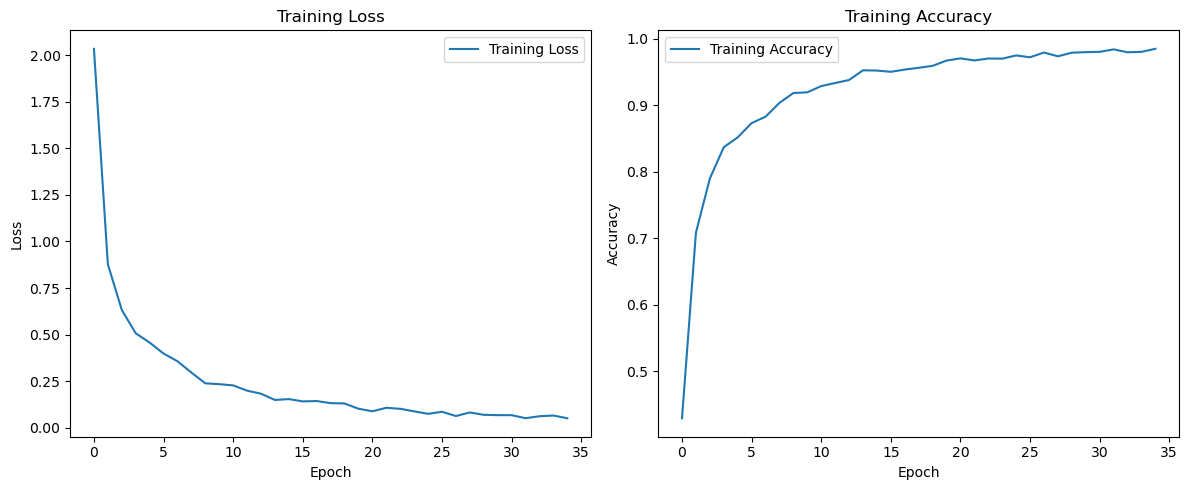


Evaluating on standard test set...
Test data shape: (1200, 10000)
Test labels shape: (1200,)
Test Accuracy: 0.9608

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       120
           1       0.97      0.95      0.96       120
           2       0.94      0.97      0.96       120
           3       0.96      0.91      0.94       120
           4       0.97      0.95      0.96       120
           5       0.93      0.97      0.95       120
           6       0.97      0.95      0.96       120
           7       0.94      0.98      0.96       120
           8       0.97      0.97      0.97       120
           9       0.98      0.98      0.98       120

    accuracy                           0.96      1200
   macro avg       0.96      0.96      0.96      1200
weighted avg       0.96      0.96      0.96      1200



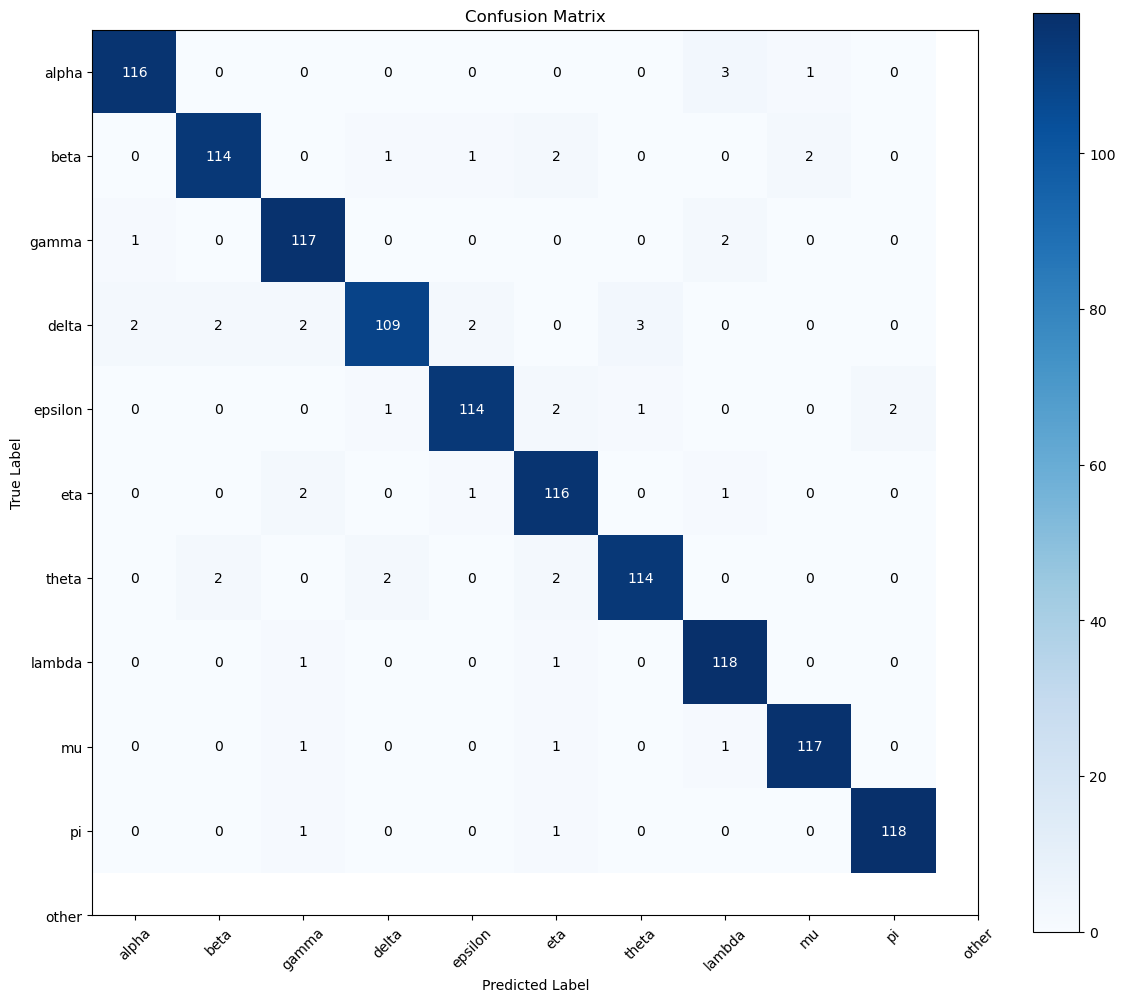


Evaluating on hard test set...
Hard test data shape: (1210, 10000)
Hard test labels shape: (1210,)
Hard Test Accuracy: 0.9405

Classification Report:
              precision    recall  f1-score   support

          -1       0.16      0.90      0.27        10
           0       0.99      0.92      0.95       120
           1       0.99      0.93      0.96       120
           2       0.97      0.96      0.96       120
           3       0.98      0.90      0.94       120
           4       0.97      0.95      0.96       120
           5       0.97      0.96      0.96       120
           6       0.98      0.93      0.96       120
           7       0.98      0.98      0.98       120
           8       0.98      0.94      0.96       120
           9       0.99      0.94      0.97       120

    accuracy                           0.94      1210
   macro avg       0.90      0.94      0.90      1210
weighted avg       0.97      0.94      0.95      1210



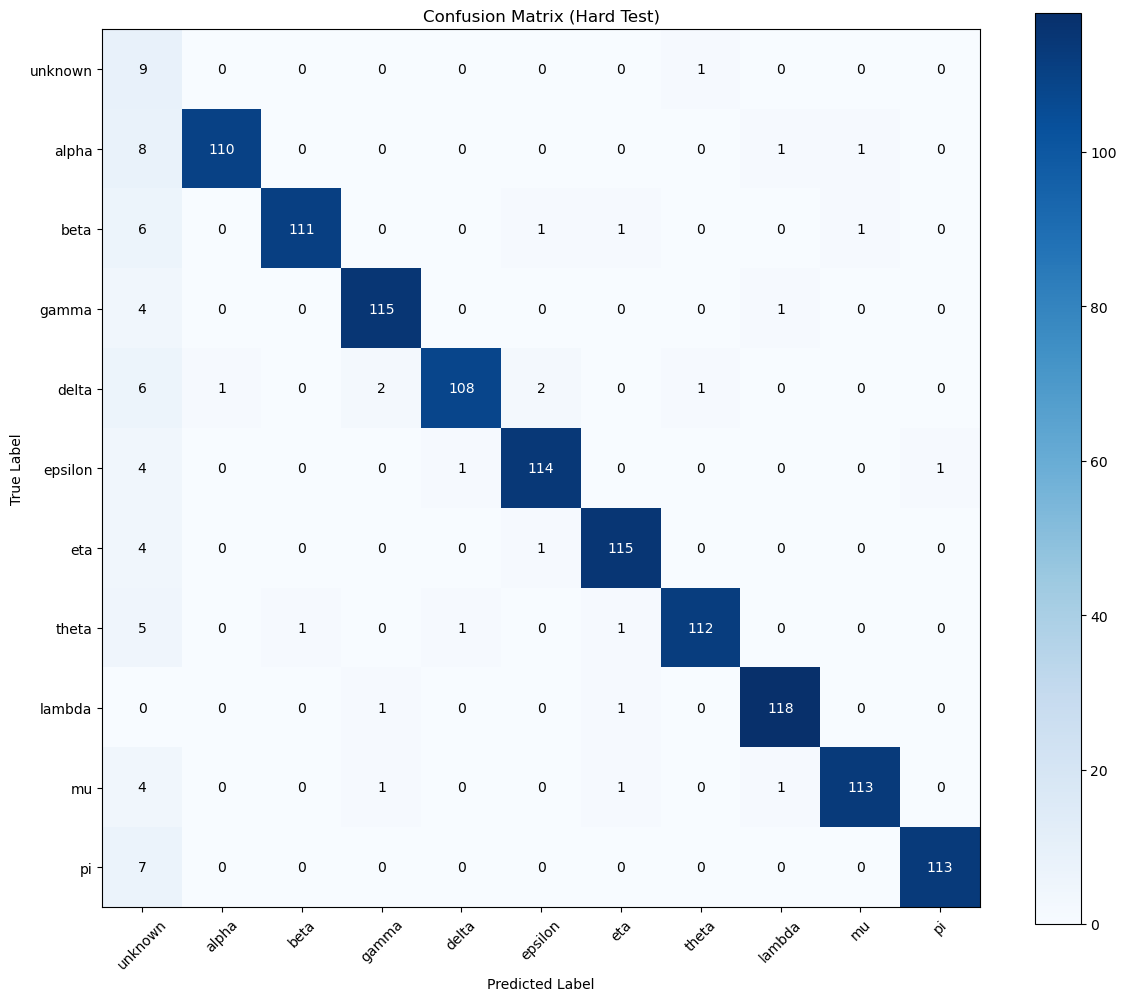

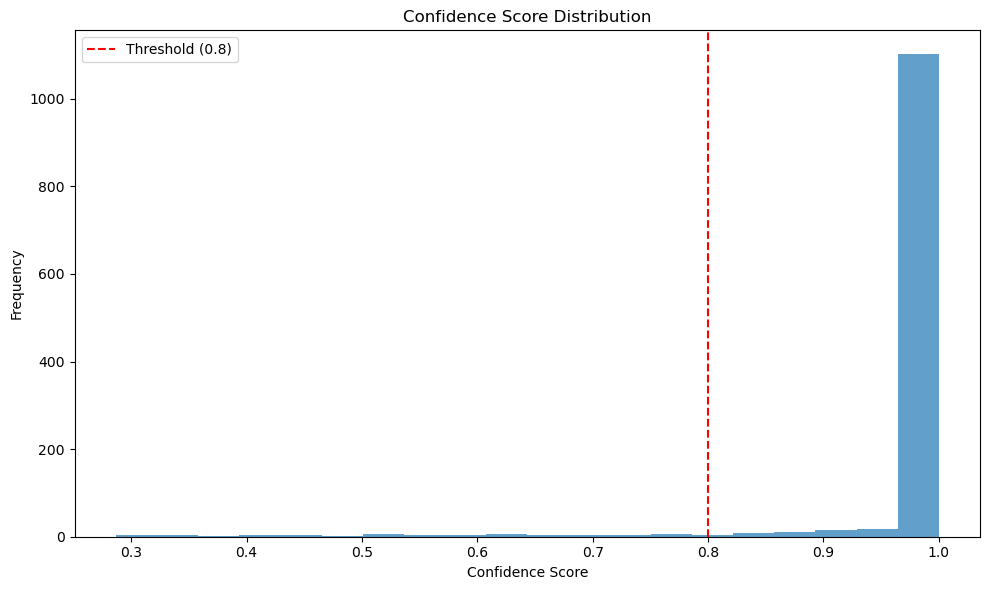

In [71]:
#Contorl flags
RETRAIN_MODEL = True  # Set to False to skip training and just use saved model
RUN_STANDARD_TEST =True  # Set to True to run standard test
RUN_HARD_TEST = True  # Set to True to run hard test
NO_VAL_MODEL_PATH = 'greek_letter_model.pth'

#main execution cell
if __name__ == "__main__":
    # Load data
    print("Loading training data...")
    data = np.genfromtxt('Data/x_train_project.csv', delimiter=',')
    targets = np.genfromtxt('Data/t_train_project.csv', delimiter=',')

    # Stratified partition of the data into training/test sets
    x_train, x_test, t_train, t_test = train_test_split(data, targets, test_size=0.2, random_state=42, stratify=targets)  # Added random_state

    # Generate unknown to the test data set
    hard_test_data, hard_test_labels = add_unknown_data(x=x_test, t=t_test, num_of_unknown=10)
    
    # Train model only if RETRAIN_MODEL is True
    if RETRAIN_MODEL:
        print("Training model...")
        model = train(data=x_train, targets=t_train)
    else:
        print("Skipping training, using saved model...")

    # Test on standard test set only if RUN_STANDARD_TEST is True
    if RUN_STANDARD_TEST:
        print("\nEvaluating on standard test set...")
        test_acc, test_preds = test(data=x_test, labels=t_test, model_path=NO_VAL_MODEL_PATH)
        
    # Test on hard test set only if RUN_HARD_TEST is True
    if RUN_HARD_TEST:
        try:
            print("\nEvaluating on hard test set...")
            hard_test_acc, hard_test_preds = test_hard(data=hard_test_data, labels=hard_test_labels, model_path=NO_VAL_MODEL_PATH)
        except FileNotFoundError:
            print("Hard test set files not found. Skipping hard test evaluation.")
